<a href="https://colab.research.google.com/github/Vitaliy-Chernenko/Furniture-shop/blob/main/Portfolio_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Project


Мета проєкту проаналізувати ефектифність роботи магазину меблів, знайти закономірності, і запропонувати висновок на основі статистичного аналізу.
Для цих задач я обрав такі інструменти:

1. SQL для аналізу данних, використання сортування замінення і тд; через його зручність в читанні розумінні та аналізу
2. Python вважаю доцільним використовувати тільки в статистичному аналізі, через підтримку багатьох статистичних бібліотек
3. Tableu для візуалізації основних тенденції.

# Аналіз датасету та короткий опис

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

client = bigquery.Client(project="data-analytics-mate")

query = """
SELECT
    ses.date AS order_date,
    spr.ga_session_id,
    spr.continent,
    spr.country,
    spr.device,
    spr.browser,
    spr.mobile_model_name,
    spr.operating_system,
    spr.language AS browser_language,
    spr.medium AS traffic_source,
    spr.channel AS traffic_channel,
    acc.id AS user_id,
    acc.is_verified,
    acc.is_unsubscribed,
    prd.category AS product_category,
    prd.name AS product_name,
    prd.price,
    prd.short_description
FROM `data-analytics-mate.DA.session_params` AS spr
INNER JOIN `data-analytics-mate.DA.order` AS ord
    ON spr.ga_session_id = ord.ga_session_id
LEFT JOIN `data-analytics-mate.DA.session` AS ses
    ON ord.ga_session_id = ses.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account_session` AS acs
    ON ses.ga_session_id = acs.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account` AS acc
    ON acs.account_id = acc.id
LEFT JOIN `data-analytics-mate.DA.product` AS prd
    ON ord.item_id = prd.item_id
"""

df = client.query(query).to_dataframe()
df.head()


,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,browser_language,traffic_source,traffic_channel,user_id,is_verified,is_unsubscribed,product_category,product_name,price,short_description
0,2020-12-24,5726438444,(not set),(not set),desktop,Chrome,Chrome,Web,None,referral,Paid Search,<NA>,<NA>,<NA>,Cabinets & cupboards,LIXHULT,356.0,"Wall-mounted cabinet combination, 50x25x50 cm"
1,2020-12-13,5614986004,(not set),(not set),desktop,<Other>,<Other>,Web,en-ca,organic,Organic Search,<NA>,<NA>,<NA>,Tables & desks,BEKANT,1325.0,"Desk, 140x60 cm"
2,2020-11-05,8542454082,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Chairs,ANTILOP,20.0,Cover
3,2020-12-16,1717992506,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Beds,SUNDVIK,849.0,"Ext bed frame with slatted bed base, 80x200 cm"
4,2021-01-16,8416141289,(not set),(not set),desktop,Chrome,Safari,Web,en-gb,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,ALGOT,130.0,"Wall upright/drying rack, 66x41x197 cm"


Основні категорії даних:

**Сесії та замовлення:**

order_date — дата замовлення.

ga_session_id — унікальний ідентифікатор сесії.

**Географія та пристрій:**

continent, country — континент і країна користувача.

device, browser, mobile_model_name, operating_system — характеристики пристрою.

browser_language — мова браузера.

**Трафік:**

traffic_source, traffic_channel — джерело та канал трафіку.

**Користувач:**

user_id — ідентифікатор користувача.

email_verified, subscribed — статус підтвердження email та підписки на розсилку (Yes- підтверджений(підписаний на розсилку), No- не підтверджений(не підписаний на розсилку)) .

**Продукт:**

product_category, product_name, price, short_description — інформація про товар, який замовили.

# Аналаіз пропущених значеннь

In [ ]:
print("Пропущені значення у стовпчиках:")
print(df.isna().sum(), "\n")

print("Відсоток пропусків у стовпчиках:")
print(round(df.isna().sum() / len(df) * 100, 2), "\n")

Пропущені значення у стовпчиках:
order_date               0
ga_session_id            0
continent                0
country                  0
device                   0
browser                  0
mobile_model_name        0
operating_system         0
browser_language     11007
traffic_source           0
traffic_channel          0
user_id              30757
email_verified           0
subscribed               0
product_category         0
product_name             0
price                    0
short_description        0
dtype: int64 

Відсоток пропусків у стовпчиках:
order_date            0.00
ga_session_id         0.00
continent             0.00
country               0.00
device                0.00
browser               0.00
mobile_model_name     0.00
operating_system      0.00
browser_language     32.82
traffic_source        0.00
traffic_channel       0.00
user_id              91.71
email_verified        0.00
subscribed            0.00
product_category      0.00
product_name          0.00
p

Маємо **11007** пропусків в колонці browser_language, що складє **33%**  пропущених значеннь від загальної кількості. Це не критичні пропуски, вони можуть виникати у результаті відівідування системи через додатки які не передають відомості про мови, або використання анонімних гостьових сесії. Я пропоную замінити ці значення на "Unknown" для зручності роботи в майбутньому з візуалізацями.

Також маємо **30757** пропусків в колонці user_id, що складає **92%** пропущених значень від загальної кількості, це не є помилкою, це реальна поведінка користувачів, не всі замовлення роблять зареєстровані користувачі. В цьому випадку ми також можемо замінити ці значення, але на мою думку це буде недоцільно, тож залишимо пропущені значення.

Також важаю доцільним попрацювати з значеннями **not set** в стовпчику **country**.

Також треба замінити значення **1/0**в колонках acc.is_verified, acc.is_unsubscribed на **Yes/No** для зручності читання.

In [ ]:
query_1 = """
SELECT
  ses.date AS order_date,
  spr.ga_session_id,
  CASE
    WHEN spr.continent = "(not set)" THEN "Unknown"
    ELSE spr.continent
END AS continent,
  CASE
    WHEN spr.country = "(not set)" THEN "Unknown"
    ELSE spr.country
END AS country,
  spr.device,
  spr.browser,
  spr.mobile_model_name,
  spr.operating_system,
  spr.language AS browser_language,
  spr.medium AS traffic_source,
  spr.channel AS traffic_channel,
  acc.id AS user_id,
  CASE
    WHEN acc.is_verified = 1 THEN 'Yes'
    ELSE 'No'
END AS email_verified,
  CASE
    WHEN acc.is_unsubscribed = 0 THEN 'Yes'
    ELSE 'No'
END AS subscribed,
  prd.category AS product_category,
  prd.name AS product_name,
  prd.price,
  prd.short_description
FROM
  `data-analytics-mate.DA.session_params` AS spr
INNER JOIN
  `data-analytics-mate.DA.order` AS ord
ON
  spr.ga_session_id = ord.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.session` AS ses
ON
  ord.ga_session_id = ses.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.account_session` AS acs
ON
  ses.ga_session_id = acs.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.account` AS acc
ON
  acs.account_id = acc.id
LEFT JOIN
  `data-analytics-mate.DA.product` AS prd
ON
  ord.item_id = prd.item_id
  """
corect = client.query(query_1).to_dataframe()
corect.head()

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,browser_language,traffic_source,traffic_channel,user_id,email_verified,subscribed,product_category,product_name,price,short_description
0,2020-12-24,5726438444,Unknown,Unknown,desktop,Chrome,Chrome,Web,None,referral,Paid Search,<NA>,No,No,Cabinets & cupboards,LIXHULT,356.0,"Wall-mounted cabinet combination, 50x25x50 cm"
1,2020-12-13,5614986004,Unknown,Unknown,desktop,<Other>,<Other>,Web,en-ca,organic,Organic Search,<NA>,No,No,Tables & desks,BEKANT,1325.0,"Desk, 140x60 cm"
2,2020-11-05,8542454082,Unknown,Unknown,desktop,Chrome,Safari,Web,en-us,(data deleted),Undefined,<NA>,No,No,Chairs,ANTILOP,20.0,Cover
3,2020-12-16,1717992506,Unknown,Unknown,mobile,Safari,iPhone,Web,en-us,(data deleted),Undefined,<NA>,No,No,Beds,SUNDVIK,849.0,"Ext bed frame with slatted bed base, 80x200 cm"
4,2021-01-16,8416141289,Unknown,Unknown,desktop,Chrome,Safari,Web,en-gb,(none),Direct,<NA>,No,No,Bookcases & shelving units,ALGOT,130.0,"Wall upright/drying rack, 66x41x197 cm"


# Аналітичні завдання виконані за допомогою SQL

**Визначити топ-10 категорій продуктів за доходом у розрізі країн. Порівняльна статистика**

Америка є найприбутковішим регіоном, лідируючи одразу у шести категоріях товарів.

Це свідчить про високий попит на продукцію в цьому регіоні та потенціал для подальшого розвитку маркетингових кампаній і продажів саме для американського ринку.

Бізнес може зосередити ресурси на розширенні асортименту та просуванні продуктів у цьому регіоні, оскільки тут найбільша віддача.

Індія також є одним з лідерів по продажам, але тільки в двох категорія, бачимо прийняття наших продуктів, але треба спробувати підвищити продажі за допомогою рекламних компаній, або акційних пропозицій.

In [ ]:
query_2 = """
SELECT
  CASE WHEN spr.country = "(not set)" THEN "Unknown" ELSE spr.country END AS country,
  prd.category,
  ROUND(SUM(prd.price), 3) AS revenue
FROM
  `data-analytics-mate.DA.product` AS prd
LEFT JOIN `data-analytics-mate.DA.order` AS ord
  ON prd.item_id = ord.item_id
LEFT JOIN `data-analytics-mate.DA.session_params` AS spr
  ON ord.ga_session_id = spr.ga_session_id
GROUP BY country, prd.category
ORDER BY revenue DESC
"""
country_df = client.query(query_2).to_dataframe()
country_df.head(10)

,country,category,revenue
0,United States,Sofas & armchairs,3707144.5
1,United States,Chairs,2619773.8
2,United States,Beds,2213058.0
3,United States,Bookcases & shelving units,1567606.9
4,United States,Cabinets & cupboards,994545.5
5,United States,Outdoor furniture,929245.2
6,India,Sofas & armchairs,788430.0
7,United States,Tables & desks,777865.0
8,Canada,Sofas & armchairs,692427.5
9,India,Chairs,544309.2


**Загальна статистика продажів за категоріями**

Існує пряма залежність між найпопулярнішими категоріями загалом і в розрізі країн. Це легко пояснити: Америка є найбільшим ринком для нашого магазину, тому саме категорії, які активно купують американські користувачі, формують загальний рейтинг найпопулярніших товарів.

In [ ]:
query_top10_category = """
SELECT
  prd.category,
  ROUND(SUM(prd.price), 3) AS revenue
FROM
  `data-analytics-mate.DA.product` AS prd
LEFT JOIN `data-analytics-mate.DA.order` AS ord
  ON prd.item_id = ord.item_id
LEFT JOIN `data-analytics-mate.DA.session_params` AS spr
  ON ord.ga_session_id = spr.ga_session_id
GROUP BY prd.category
ORDER BY revenue DESC
LIMIT 10
"""

top10_category_df = client.query(query_top10_category).to_dataframe()
top10_category_df.head(10)


,category,revenue
0,Sofas & armchairs,8388254.5
1,Chairs,6147748.8
2,Beds,4919725.0
3,Bookcases & shelving units,3640818.1
4,Cabinets & cupboards,2336499.5
5,Outdoor furniture,2142222.2
6,Tables & desks,1903061.5
7,Chests of drawers & drawer units,906562.5
8,Bar furniture,735503.0
9,Wardrobes,494783.5


**Проаналізуй продажі у розрізі типів та моделей девайсів**

Аналіз показує, що левова частка продажів припадає на користувачів, які використовують десктопні пристрої.Разом браузери Chrome і Safari на настільних комп'ютерах становлять майже 48.28% від загальної кількості продажів.

Настільні комп'ютери (Desktop) забезпечують найбільший обсяг продажів:

Chrome на десктопах лідирує з часткою 27.91%.

Safari на десктопах займає друге місце з 20.37%.

Мобільні пристрої (Mobile) також мають значний внесок:

iPhone є найпопулярнішим мобільним пристроєм для покупок, складаючи 20.33% від загальних продажів.

Інші мобільні пристрої, об'єднані як <Other>, формують 18.10% продажів.

Цей розподіл свідчить про те, що клієнти частіше завершують покупки на настільних комп'ютерах, є пропозиція покращити якість сайту для користування на телефоні, бо є вірогідність що сайт не є оптимізованим для користування на телефоні.


In [ ]:
# SQL-запит: продажі у % по девайсам і моделям
query_3 = """
WITH device_sales AS (
  SELECT
    spr.device,
    spr.mobile_model_name,
    COUNT(ord.item_id) AS product_count
  FROM
    `data-analytics-mate.DA.product` AS prd
  LEFT JOIN `data-analytics-mate.DA.order` AS ord
    ON prd.item_id = ord.item_id
  LEFT JOIN `data-analytics-mate.DA.session_params` AS spr
    ON ord.ga_session_id = spr.ga_session_id
  GROUP BY spr.device, spr.mobile_model_name
),
total_sales AS (
  SELECT SUM(product_count) AS total_count
  FROM device_sales
)
SELECT
  d.device,
  d.mobile_model_name,
  d.product_count,
  ROUND(d.product_count / t.total_count * 100, 2) AS percent_of_total
FROM device_sales d
CROSS JOIN total_sales t
ORDER BY percent_of_total DESC
"""

# Виконання запиту
device_sales_df = client.query(query_3).to_dataframe()

# Перегляд перших рядків
device_sales_df.head()


,device,mobile_model_name,product_count,percent_of_total
0,desktop,Chrome,9359,27.91
1,desktop,Safari,6831,20.37
2,mobile,iPhone,6819,20.33
3,mobile,<Other>,6069,18.10
4,desktop,ChromeBook,1877,5.60


Органічний трафік є найважливішим каналом продажів, генеруючи 34.08% від загальної кількості проданих товарів. Це свідчить про високу ефективність SEO-оптимізації та контент-маркетингу, оскільки користувачі знаходять сайт природним шляхом через пошукові системи.

Джерело (none) займає друге місце з часткою 23.26%. Це можуть бути прямі заходи на сайт (коли користувач вводить URL-адресу безпосередньо) або трафік, який не було ідентифіковано інструментами аналітики.

Реферальний трафік (переходи з інших сайтів) забезпечує 17.89% продажів, що вказує на успішні партнерства, згадки або публікації на зовнішніх ресурсах.

Категорія <Other> становить 14.32%, а (data deleted) — 6.25%. Ці джерела потребують додаткового аналізу, але їхня сукупна частка є значною.



In [ ]:
# SQL-запит: продажі у розрізі джерел трафіку (% від загальних)
query_traffic = """
WITH traffic_sales AS (
  SELECT
    spr.medium AS traffic_source,
    COUNT(ord.item_id) AS product_count
  FROM
    `data-analytics-mate.DA.order` AS ord
  LEFT JOIN `data-analytics-mate.DA.session_params` AS spr
    ON ord.ga_session_id = spr.ga_session_id
  GROUP BY spr.medium
),
total_sales AS (
  SELECT SUM(product_count) AS total_count
  FROM traffic_sales
)
SELECT
  t.traffic_source,
  t.product_count,
  ROUND(t.product_count / ts.total_count * 100, 2) AS percent_of_total
FROM traffic_sales t
CROSS JOIN total_sales ts
ORDER BY percent_of_total DESC
"""

# Виконання запиту
traffic_sales_df = client.query(query_traffic).to_dataframe()

# Перегляд перших рядків
traffic_sales_df.head()


,traffic_source,product_count,percent_of_total
0,organic,11430,34.08
1,(none),7800,23.26
2,referral,6001,17.89
3,<Other>,4803,14.32
4,(data deleted),2097,6.25


**Відсоток зареєстрованих користувачів, які підтвердили email**

На основі цієї метрики бачимо, що 72 % користувачів підтвердили свою почту, що є дуже гарним показником, і означає довіру до нашої кампанії, і актуальність розсилок які ми робимо, маємо рухатись в тому ж напрямку без змін.

**Який відсоток зареєстрованих користувачів відписався від розсилки?**

17% це доситьь високий показник відписок, треба встановити причину такої незадовільної тенденції, можливо це повязано з великою частотою листів,треба провести опитування серед клієнтів, які відписались, і отримати фідбек.

In [ ]:
# SQL-запит для відсотка підтверджених email
query_verified = """
SELECT
  ROUND(SUM(CASE WHEN acc.is_verified = 1 THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS verified_percent
FROM
  `data-analytics-mate.DA.account` AS acc
"""

# SQL-запит для відсотка відписаних користувачів
query_unsubscribed = """
SELECT
  ROUND(SUM(CASE WHEN acc.is_unsubscribed = 1 THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS unsubscribed_percent
FROM
  `data-analytics-mate.DA.account` AS acc
"""

# Виконання запитів
verified_df = client.query(query_verified).to_dataframe()
unsubscribed_df = client.query(query_unsubscribed).to_dataframe()

# Вивід результатів
print("Відсоток підтверджених email:")
print(verified_df)

print("\nВідсоток відписаних користувачів:")
print(unsubscribed_df)


Відсоток підтверджених email:
   verified_percent
0             71.88

Відсоток відписаних користувачів:
   unsubscribed_percent
0                 17.05


**Чи відрізняється поведінка (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний?**

Бачимо значну різницію між загалним прибутком та загальною кількостю придбаних товарів, це не є чимось не звичним, це свідчить про прихильність і відданість нашому магазину, але нам потрібна покращувати цей показник впроваджуючі реформи які зменшать кількість відписаних користувачів

In [ ]:
# SQL-запит: порівняння продажів між підписаними та відписаними користувачами
query_subscriptions = """
SELECT
  CASE WHEN acc.is_unsubscribed = 1 THEN 'Unsubscribed' ELSE 'Subscribed' END AS subscription_status,
  COUNT(ord.item_id) AS total_products,
  ROUND(SUM(prd.price), 2) AS total_revenue
FROM
  `data-analytics-mate.DA.account` AS acc
LEFT JOIN `data-analytics-mate.DA.account_session` AS acs
  ON acc.id = acs.account_id
LEFT JOIN `data-analytics-mate.DA.session` AS ses
  ON acs.ga_session_id = ses.ga_session_id
LEFT JOIN `data-analytics-mate.DA.order` AS ord
  ON ses.ga_session_id = ord.ga_session_id
LEFT JOIN `data-analytics-mate.DA.product` AS prd
  ON ord.item_id = prd.item_id
GROUP BY subscription_status
"""

# Виконання запиту
subscriptions_df = client.query(query_subscriptions).to_dataframe()

# Вивід результату
subscriptions_df.head()


,subscription_status,total_products,total_revenue
0,Subscribed,2334,2150796.9
1,Unsubscribed,447,431721.6


# Python візуалізації

**Знайди загальні продажі за кожну дату, створи візуалізацію загальної динаміки продажів**
**Чи спостерігається сезонність продажів?**

Маємо яскраво виражену святкову динаміку продажів у грудні, для бізнесу критично важливо заздалегідь готуватися до цього періоду: планувати запаси, маркетингові кампанії та персонал.

Спад продажів на початку січня і в періоди між піками вимагає стратегії для підтримки доходу. Це можуть бути спеціальні пропозиції, акції або робота над лояльністю клієнтів.

Знаючи, коли відбуваються основні піки продажів, бізнес може більш ефективно прогнозувати попит, керувати запасами та фінансовими потоками, що дозволяє уникнути дефіциту товару в піковий період і надлишку в низький.


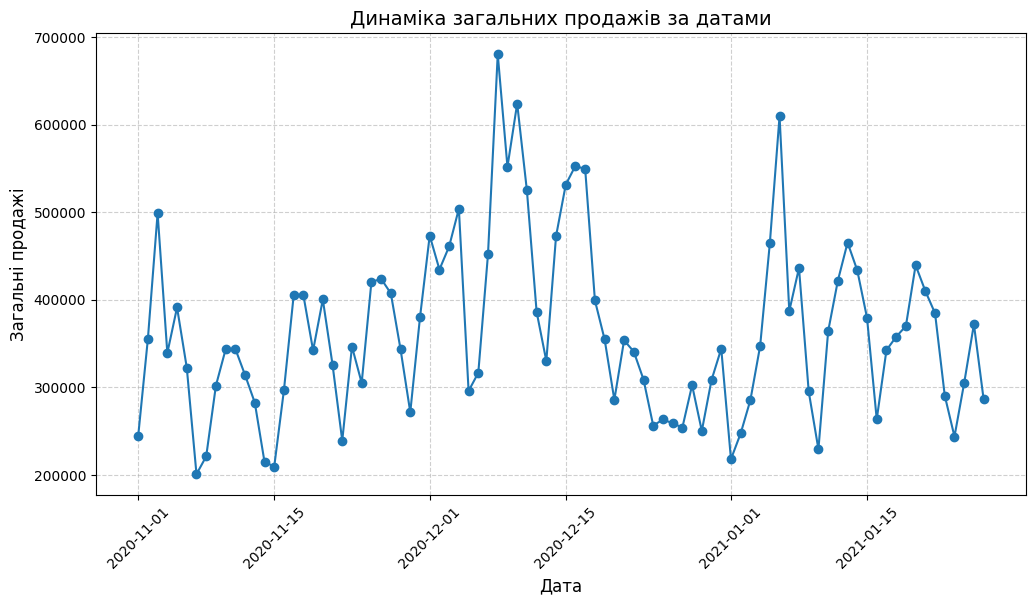

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# групування за датами
sales_by_date = (
    corect.groupby("order_date")["price"]
    .sum()
    .reset_index()
    .sort_values("order_date")
)

# візуалізація
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date["order_date"], sales_by_date["price"], marker="o")

plt.title("Динаміка загальних продажів за датами", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Загальні продажі", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


**Проаналізуй динаміку продажів в Америці, Азії та Європі, відображай різні континенти різними кольорами**

Бачимо безумовне лідерство Америки, що я досить спірним показником, через залежність від одного континенту, ми маємо ризики тож, ми повинні розвивати інші континенти, щоб в разі світових змін не збанкрутувати.

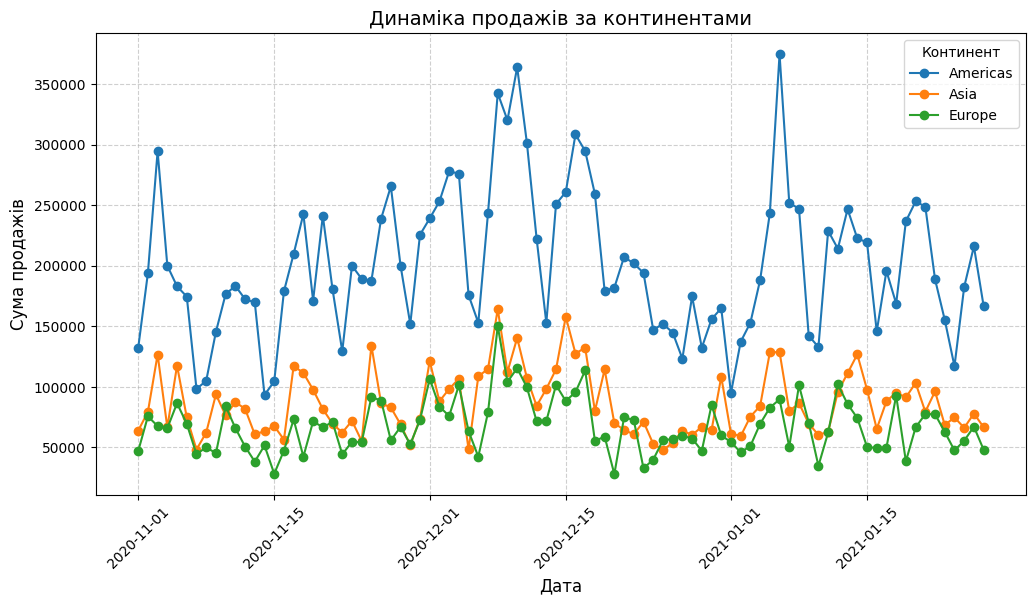

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# залишаємо лише потрібні континенти
continents = ["Americas", "Asia", "Europe"]
df_filtered = corect[corect["continent"].isin(continents)]

# групування
sales_by_continent = (
    df_filtered.groupby(["order_date", "continent"])["price"]
    .sum()
    .reset_index()
    .sort_values("order_date")
)

# візуалізація
plt.figure(figsize=(12, 6))

for cont in continents:
    subset = sales_by_continent[sales_by_continent["continent"] == cont]
    plt.plot(subset["order_date"], subset["price"], marker="o", label=cont)

plt.title("Динаміка продажів за континентами", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Сума продажів", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Континент")

plt.show()


**Проаналізуй динаміку продажів у розрізі каналів трафіку**

Висновки Зроблені в блоці з SQL

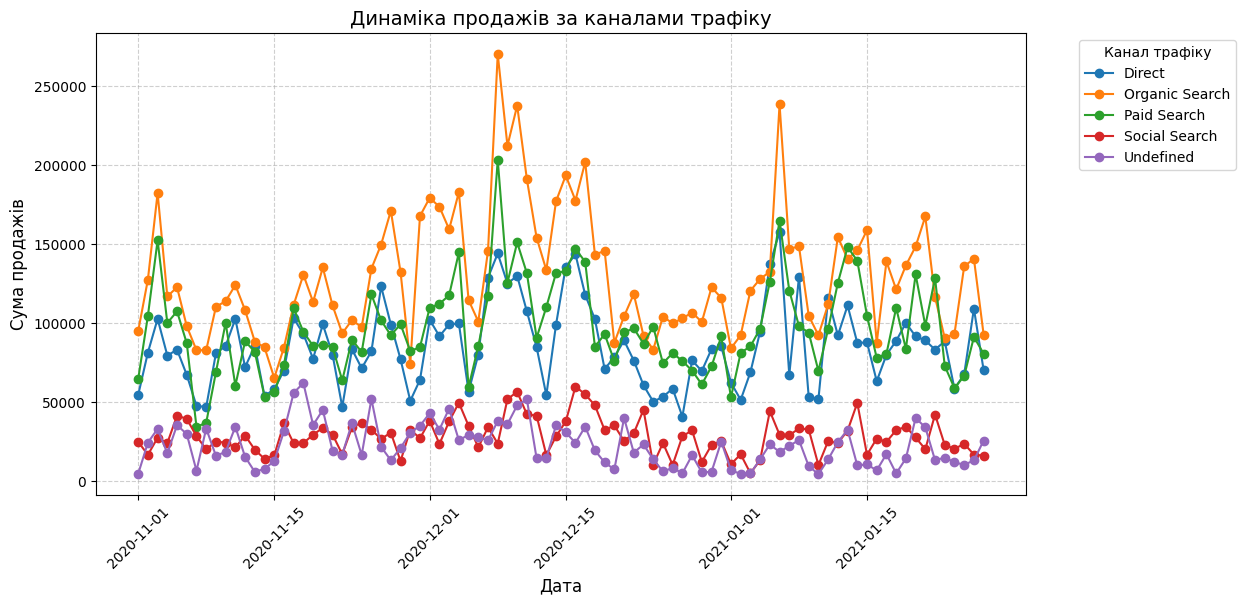

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# групування за датою та каналом трафіку
sales_by_channel = (
    corect.groupby(["order_date", "traffic_channel"])["price"]
    .sum()
    .reset_index()
    .sort_values("order_date")
)

# візуалізація
plt.figure(figsize=(12, 6))

for channel in sales_by_channel["traffic_channel"].unique():
    subset = sales_by_channel[sales_by_channel["traffic_channel"] == channel]
    plt.plot(subset["order_date"], subset["price"], marker="o", label=channel)

plt.title("Динаміка продажів за каналами трафіку", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Сума продажів", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Канал трафіку", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()


**Проаналізуй динаміку продажів у розрізі типів девайсів**

Висновки зроблені в блоці з SQL

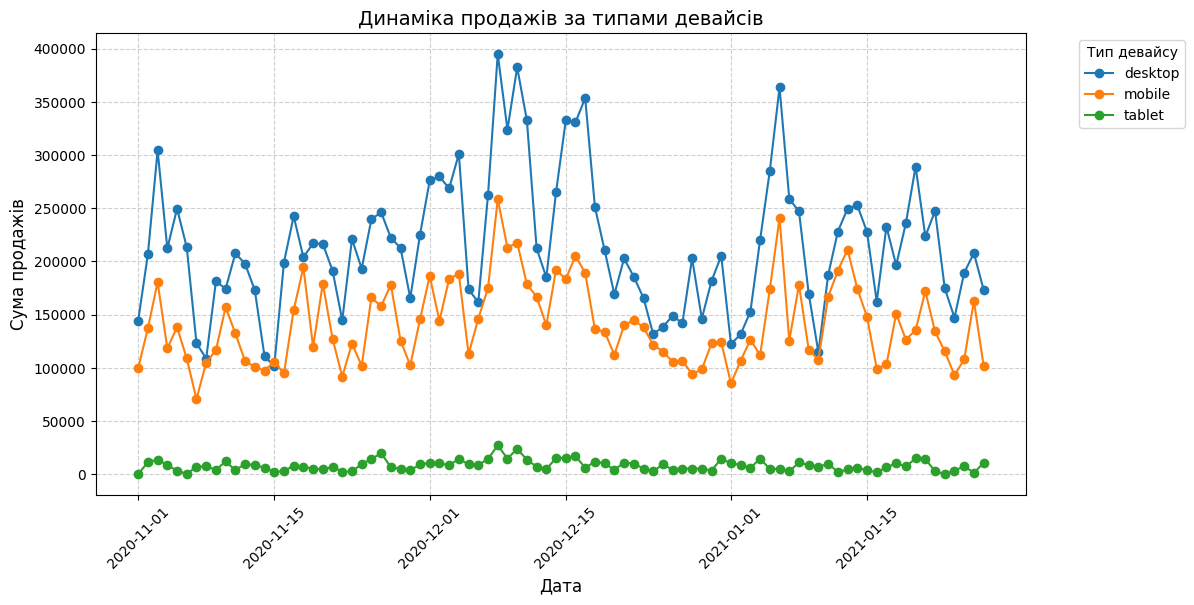

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# групування за датою та типом девайсу
sales_by_device = (
    corect.groupby(["order_date", "device"])["price"]
    .sum()
    .reset_index()
    .sort_values("order_date")
)

# візуалізація
plt.figure(figsize=(12, 6))

for dev in sales_by_device["device"].unique():
    subset = sales_by_device[sales_by_device["device"] == dev]
    plt.plot(subset["order_date"], subset["price"], marker="o", label=dev)

plt.title("Динаміка продажів за типами девайсів", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Сума продажів", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Тип девайсу", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()


# Python pivot table

**Створи зведену таблицю, яка показує кількість сесій у розрізі каналів трафіку та типів девайсів**

Основний канал трафіку — органічний пошук (SEO), який забезпечує найбільший обсяг сесій.
Головний пристрій — desktop, але mobile також має значну частку, тому мобільну версію сайту варто підтримувати на високому рівні.
Tablet — мінімальний вплив, можна не інвестувати додаткові ресурси.

In [ ]:
pivot_sessions = (
    corect[(corect["traffic_channel"] != "Unknown") & (corect["device"] != "Unknown")]
    .pivot_table(
        index="traffic_channel",
        columns="device",
        values="ga_session_id",
        aggfunc="nunique",  # унікальні сесії
        fill_value=0
    )
)

print("Кількість сесій за каналами та девайсами:")
print(pivot_sessions)


Кількість сесій за каналами та девайсами:
device           desktop  mobile  tablet
traffic_channel                         
Direct              4655    2985     160
Organic Search      7011    4655     255
Paid Search         5261    3574     207
Social Search       1594    1065      57
Undefined           1181     834      44


**Створи зведену таблицю, яка показує загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)**

Американський ринок є домінуючим і критично важливим для компанії, адже забезпечує більшість продажів у всіх ключових категоріях. Найприбутковішими є категорії "Sofas & armchairs" та "Chairs", що свідчить про високий попит на меблі для сидіння. Водночас ринки Європи та Канади відстають за обсягами, і їх розвиток може стати потенційною зоною зростання.

In [ ]:
# топ-10 категорій
top_categories = (
    corect.groupby("product_category")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# топ-5 країн
top_countries = (
    corect.groupby("country")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

pivot_sales = (
    corect[corect["product_category"].isin(top_categories) & corect["country"].isin(top_countries)]
    .pivot_table(
        index="product_category",
        columns="country",
        values="price",
        aggfunc="sum",
        fill_value=0
    )
)

print("Загальні продажі (топ-10 категорій × топ-5 країн):")
print(pivot_sales)


Загальні продажі (топ-10 категорій × топ-5 країн):
country                             Canada    France     India  \
product_category                                                 
Bar furniture                      51724.0   11199.0   57657.0   
Beds                              354772.0  116414.0  358319.5   
Bookcases & shelving units        278981.9   73830.0  364507.4   
Cabinets & cupboards              181802.0   59101.5  191888.0   
Chairs                            417740.8  134029.4  544309.2   
Chests of drawers & drawer units   71952.0   21544.5   73111.0   
Children's furniture               30264.0   14258.0   39177.0   
Outdoor furniture                 185322.8   40486.4  162289.4   
Sofas & armchairs                 692427.5  187735.0  788430.0   
Tables & desks                    132678.0   42299.0  186157.5   

country                           United Kingdom  United States  
product_category                                                 
Bar furniture           

**Перевірені vs неперевірені email у розрізі континентів**

Всі основні регіони (Americas, Europe, Asia) показують високу частку верифікованих email (70–73%), що є позитивним сигналом для маркетингових кампаній і підтверджує довіру користувачів. Африка та Океанія наразі мають малу вибірку, тому їхній вплив незначний. Основну увагу варто зосередити на Америці як ключовому ринку, а також підтримувати стабільний рівень верифікації у Європі та Азії.

In [ ]:
pivot_verified = corect.pivot_table(
    index="continent",
    columns="email_verified",
    values="user_id",
    aggfunc="nunique",
    fill_value=0
)

print("Користувачі з підтвердженим/непідтвердженим email у розрізі континентів:")
print(pivot_verified)


Користувачі з підтвердженим/непідтвердженим email у розрізі континентів:
email_verified   No   Yes
continent                
Africa           14    15
Americas        434  1098
Asia            191   473
Europe          139   384
Oceania          14    17
Unknown           0     2


**Середня ціна товарів у розрізі каналів трафіку та категорій**

Загалом, структура цін за категоріями стабільна між каналами, проте є відмінності у високовартісних категоріях. "Sofas & armchairs" та "Chairs" залишаються преміальними групами з високими середніми чеками, тоді як "Children's furniture" та "Nursery furniture" формують нижчий сегмент. Важливий момент — у каналі Undefined часто спостерігаються вищі ціни, що може бути результатом некоректного трекінгу або специфіки певних покупців. Для бізнесу це сигнал: варто приділити увагу більш детальній сегментації каналів, адже через різні канали користувачі купують товари з різним середнім чеком.

In [ ]:
pivot_avg_price = corect.pivot_table(
    index="traffic_channel",
    columns="product_category",
    values="price",
    aggfunc="mean"
)

print("Середня ціна товарів за каналами та категоріями:")
print(pivot_avg_price)


Середня ціна товарів за каналами та категоріями:
product_category  Bar furniture         Beds  Bookcases & shelving units  \
traffic_channel                                                            
Direct               634.949807  1696.956456                  486.651547   
Organic Search       647.798489  1700.985889                  474.691627   
Paid Search          709.572464  1650.062183                  481.289507   
Social Search        703.252874  1685.331818                  461.173997   
Undefined            778.767123  1642.232804                  460.979835   

product_category  Cabinets & cupboards  Café furniture       Chairs  \
traffic_channel                                                       
Direct                      978.538256      398.881579  1059.525127   
Organic Search             1062.648194      370.808511  1060.931108   
Paid Search                 980.742063      390.278351   978.565546   
Social Search               996.094241      377.000000   993.37

# Python stats

Знайди кількість сесій та загальні продажі за кожну дату. Створи візуалізацію, щоб побачити взаємозв’язок між цими метриками. Чи корелюють ці показники? Знайди відповідний коефіцієнт кореляції та проаналізуй його статистичну значущість

   order_date  sessions  total_sales
0  2020-11-01       281     244292.5
1  2020-11-02       368     355506.8
2  2020-11-03       561     498979.6
3  2020-11-04       370     339187.1
4  2020-11-05       388     391276.6


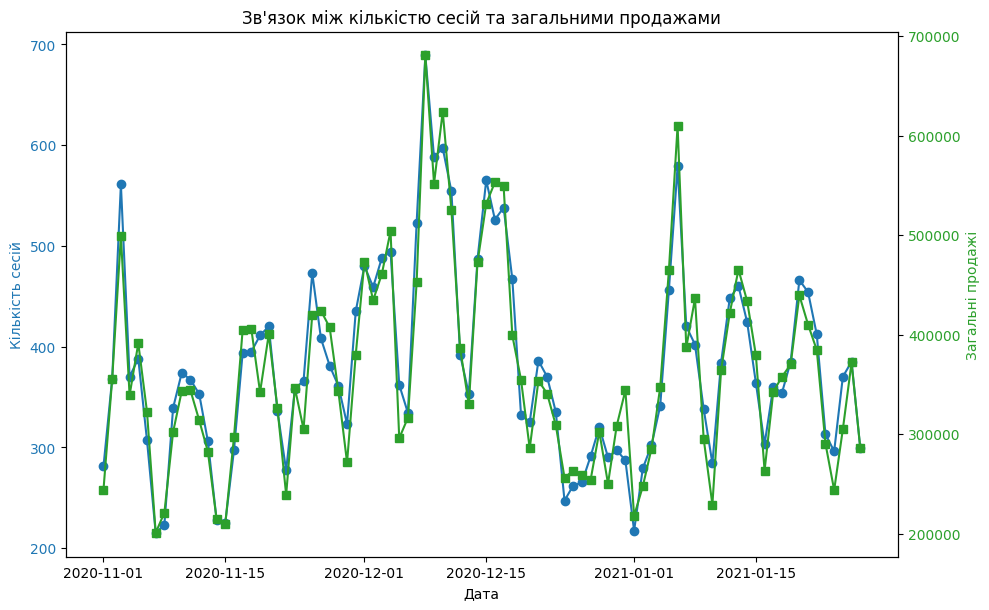

Коефіцієнт кореляції Пірсона: 0.964
P-value: 0.00000
Кореляція статистично значуща (на рівні 0.05).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Групування
agg = corect.groupby("order_date").agg(
    sessions=("ga_session_id", "nunique"),
    total_sales=("price", "sum")
).reset_index()

print(agg.head())

# 2. Візуалізація
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Дата")
ax1.set_ylabel("Кількість сесій", color="tab:blue")
ax1.plot(agg["order_date"], agg["sessions"], color="tab:blue", marker="o", label="Сесії")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Загальні продажі", color="tab:green")
ax2.plot(agg["order_date"], agg["total_sales"], color="tab:green", marker="s", label="Продажі")
ax2.tick_params(axis="y", labelcolor="tab:green")

fig.tight_layout()
plt.title("Зв'язок між кількістю сесій та загальними продажами")
plt.show()

# 3. Кореляція
corr, p_value = pearsonr(agg["sessions"], agg["total_sales"])

print(f"Коефіцієнт кореляції Пірсона: {corr:.3f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("Кореляція статистично значуща (на рівні 0.05).")
else:
    print(" Кореляція не є статистично значущою.")


Чи корелюють між собою продажі за різними каналами трафіку? Проаналізуй статистичну значущість взаємозв’язків.


traffic_channel    Direct  Organic Search  Paid Search  Social Search  \
order_date                                                              
2020-11-01        54669.5         95112.0      64688.0        25078.0   
2020-11-02        81561.5        127746.5     104780.8        16843.0   
2020-11-03       102909.5        182521.9     152641.3        27652.5   
2020-11-04        79683.6        117067.1     100332.0        24257.4   
2020-11-05        83367.6        122938.4     107648.0        41693.2   

traffic_channel  Undefined  
order_date                  
2020-11-01          4745.0  
2020-11-02         24575.0  
2020-11-03         33254.4  
2020-11-04         17847.0  
2020-11-05         35629.4  


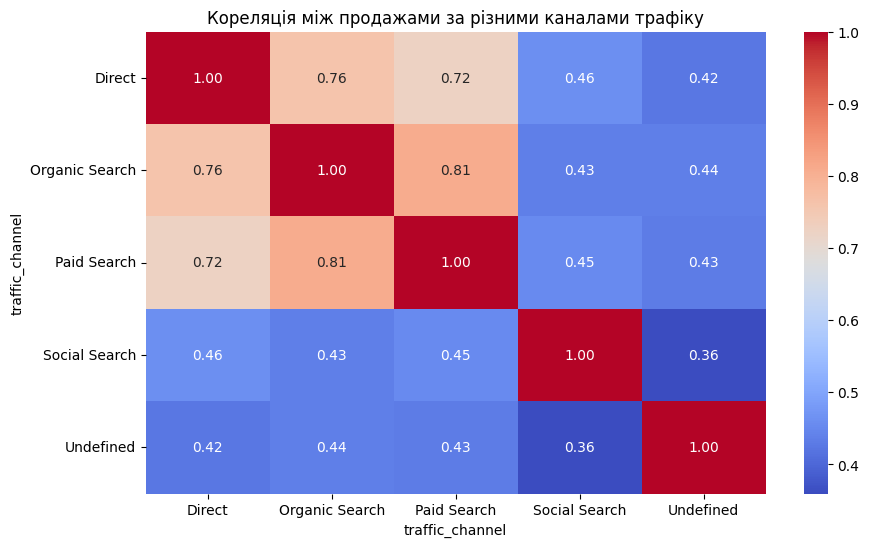

        Channel_1       Channel_2  Correlation  P-value Significant
0          Direct  Organic Search        0.760  0.00000         Yes
1          Direct     Paid Search        0.724  0.00000         Yes
2          Direct   Social Search        0.462  0.00001         Yes
3          Direct       Undefined        0.424  0.00004         Yes
4  Organic Search     Paid Search        0.808  0.00000         Yes
5  Organic Search   Social Search        0.434  0.00002         Yes
6  Organic Search       Undefined        0.435  0.00002         Yes
7     Paid Search   Social Search        0.452  0.00001         Yes
8     Paid Search       Undefined        0.430  0.00003         Yes
9   Social Search       Undefined        0.359  0.00059         Yes


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Зведена таблиця: продажі по каналах у розрізі дат
sales_by_channel = corect.groupby(["order_date", "traffic_channel"])["price"].sum().reset_index()

pivot_sales = sales_by_channel.pivot(
    index="order_date",
    columns="traffic_channel",
    values="price"
).fillna(0)

print(pivot_sales.head())

# 2. Кореляційна матриця
corr_matrix = pivot_sales.corr(method="pearson")

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Кореляція між продажами за різними каналами трафіку")
plt.show()

# 3. Перевірка статистичної значущості для кожної пари
channels = pivot_sales.columns
results = []

for i in range(len(channels)):
    for j in range(i+1, len(channels)):
        x = pivot_sales[channels[i]]
        y = pivot_sales[channels[j]]
        corr, p_val = pearsonr(x, y)
        results.append({
            "Channel_1": channels[i],
            "Channel_2": channels[j],
            "Correlation": round(corr, 3),
            "P-value": round(p_val, 5),
            "Significant": "Yes" if p_val < 0.05 else "No"
        })

results_df = pd.DataFrame(results)
print(results_df)


Статистичний аналіз відмінностей між групами.
Проаналізуй продажі за кожну дату зареєстрованих та незареєстрованих користувачів. Створи відповідні вибірки, проаналізуй розподіли даних в обох вибірках. Підбери відповідний статистичний тест для порівняння вибірок. Зроби висновок щодо статистичної значущості отриманих результатів


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

# 1. Додаємо ознаку "зареєстрований / ні"
corect["is_registered"] = corect["user_id"].notna()

# 2. Агрегуємо продажі по даті та типу користувача
sales_by_group = corect.groupby(["order_date", "is_registered"])["price"].sum().reset_index()

registered = sales_by_group[sales_by_group["is_registered"] == True]["price"]
unregistered = sales_by_group[sales_by_group["is_registered"] == False]["price"]

# Перевірка нормальності
stat_reg, p_reg = shapiro(registered)
stat_unreg, p_unreg = shapiro(unregistered)

print(f"Registered: p-value = {p_reg:.5f}")
print(f"Unregistered: p-value = {p_unreg:.5f}")

if p_reg < 0.05 or p_unreg < 0.05:
    # Використовуємо непараметричний тест
    stat, p_val = mannwhitneyu(registered, unregistered, alternative="two-sided")
    test_name = "Mann-Whitney U"
else:
    # Використовуємо t-test
    stat, p_val = ttest_ind(registered, unregistered, equal_var=False)
    test_name = "t-test"

print(f"{test_name}: статистика = {stat:.3f}, p-value = {p_val:.5f}")



Registered: p-value = 0.00730
Unregistered: p-value = 0.00262
Mann-Whitney U: статистика = 0.000, p-value = 0.00000


Зареєстровані користувачі мають інший рівень продажів, ніж незареєстровані вищий.

# Tableau visualization

https://public.tableau.com/shared/JZ23CKQP2?:display_count=n&:origin=viz_share_link